In [1]:
%matplotlib inline
import pandas as pd

In [2]:
ages = pd.read_csv('sheep_age.csv', index_col="id")
print(ages.shape)
ages.head()

(28, 1)


,age
id,
1,8
2,8
3,4
4,7
5,8


In [3]:
wins = pd.read_csv('sheep_edges.csv')
print(wins.shape)
wins.head()

(250, 3)


,source,target,weight
0,1,2,1
1,1,3,1
2,1,4,1
3,1,5,1
4,1,6,1


In [4]:
wins = pd.read_csv('sheep_edges.csv')
print(wins.shape)
wins.sort_values(by="weight", ascending=False).head(20)

(250, 3)


,source,target,weight
28,22,23,12
23,22,3,12
227,24,6,11
249,21,6,10
53,8,3,10
213,18,23,10
78,9,26,9
231,25,20,8
106,3,23,8
37,28,22,8


In [5]:
wins[wins.source==1]

,source,target,weight
0,1,2,1
1,1,3,1
2,1,4,1
3,1,5,1
4,1,6,1


In [6]:
nwins = wins.loc[:, ("source", "weight")].groupby(by="source").sum()
nwins["neg_weight"] = -nwins.weight
nwins["anti_weight"] = nwins.weight.max() - nwins.weight
nwins.head()

,weight,neg_weight,anti_weight
source,,,
1,5,-5,60
2,35,-35,30
3,63,-63,2
4,25,-25,40
5,2,-2,63


In [9]:
ages["nwins"] = nwins.weight
ages.nwins = ages.nwins.fillna(0)
ages.sort_values(by="nwins", ascending=False)

,age,nwins
id,,
22,1,65.0
3,4,63.0
8,4,56.0
9,7,52.0
7,5,43.0
18,1,35.0
2,8,35.0
28,9,32.0
14,1,31.0


In [10]:
import networkx as nx

In [28]:
G = nx.MultiDiGraph()
ages = ages.sort_values(by="id", ascending=False)
for id_ in ages.index.values:
    G.add_node(id_)
edges = [row.values[:3] for idx, row in wins.iterrows()]
print(edges[:5])
G.add_weighted_edges_from(edges)

[array([1, 2, 1], dtype=int64), array([1, 3, 1], dtype=int64), array([1, 4, 1], dtype=int64), array([1, 5, 1], dtype=int64), array([1, 6, 1], dtype=int64)]


In [90]:
all_attrs = {}
for edge in G.edges():
    src, tgt = edge
    mask = (wins.source == src) & (wins.target == tgt)
    weight = wins[mask].weight.iloc[0]
    attrs = {
        "weight": weight,
        "neg_weight": -weight,
        "inv_weight": 1. / (weight + 1e-3),
        "inv_weight_2": 1. / ((weight + 1e-3) ** 2),
        "norm_weight": weight / (wins.weight.max() - wins.weight.min()),
        "anti_norm_weight": (wins.weight.max() - weight) / (wins.weight.max() - wins.weight.min()),
        "anti_weight": wins.weight.max() - weight
    }
    all_attrs.update({(src, tgt, 0): attrs})
nx.set_edge_attributes(G, all_attrs)

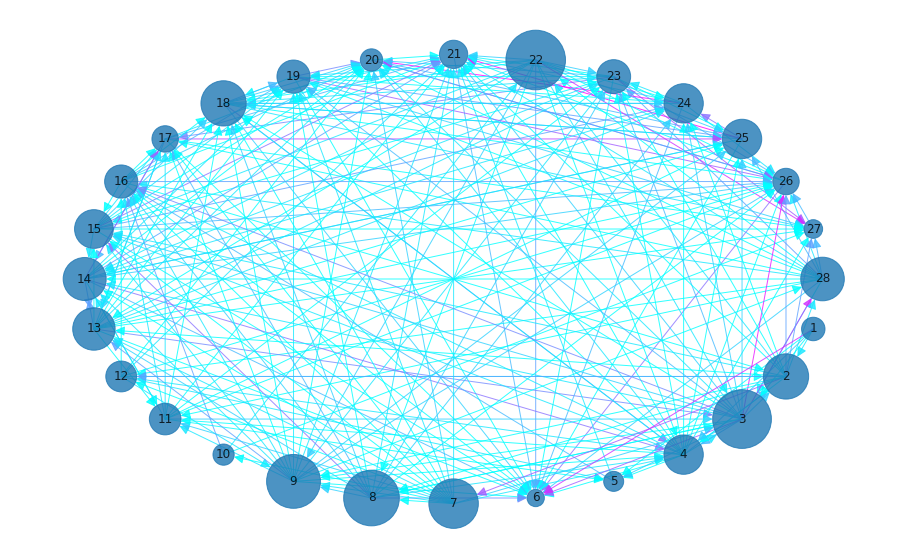

In [93]:
from matplotlib import cm
from matplotlib import pyplot as plt
# edge_colors = (1. - (wins.weight / (wins.weight.max() - wins.weight.min())))
fig, ax = plt.subplots(figsize=(16, 10))
edge_colors = (wins.weight / (wins.weight.max() - wins.weight.min()))
node_sizes = ages.nwins.values * 50 + 300
nx.draw_circular(G,
                 ax=ax,
                 node_size=node_sizes,
                 arrowsize=20,
                 font_size=12,
                 edge_color=edge_colors,
                 edge_cmap=cm.cool,
                 alpha=0.8,
                 with_labels=True)

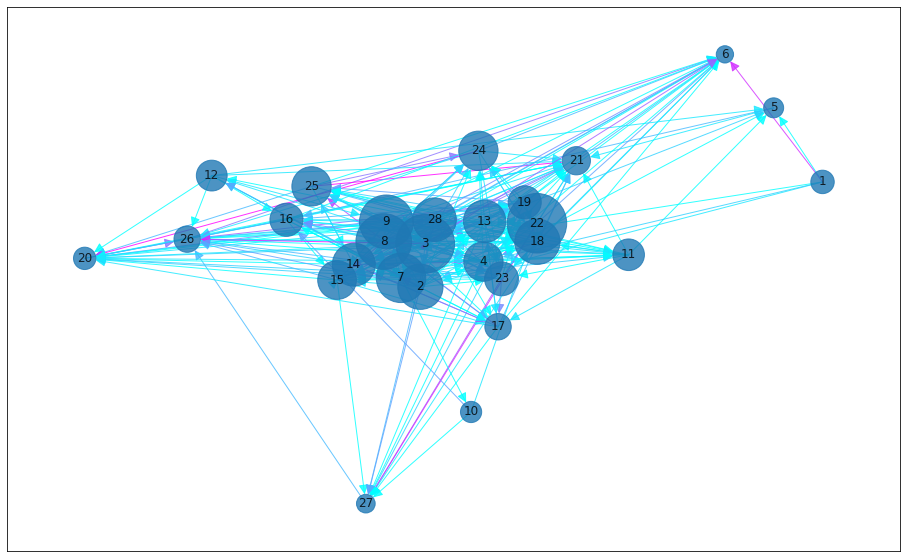

In [92]:
from matplotlib import cm
from matplotlib import pyplot as plt
# edge_colors = (1. - (wins.weight / (wins.weight.max() - wins.weight.min())))
fig, ax = plt.subplots(figsize=(16, 10))
edge_colors = (wins.weight / (wins.weight.max() - wins.weight.min()))
node_sizes = ages.nwins.values * 50 + 300
pos = nx.layout.spring_layout(G,
                              seed=42,
#                               k=5,
                              weight="norm_weight")
nx.draw_networkx(G,
                 pos=pos,
                 ax=ax,
                 node_size=node_sizes,
                 arrowsize=20,
                 font_size=12,
                 edge_color=edge_colors,
                 edge_cmap=cm.cool,
                 alpha=0.8,
                 with_labels=True)